# 4.3 - Train a model for each dataset category, comparing it to random data

In [1]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter2
from trainer import Trainer, TrainResults
from batch_encoder import Dataset, one_hot
from block_sampler import count_sectors, BlockSamplerByFile, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder, xs_encoder_one_hot
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.3-randomness-copy'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()
rawtset, rawvset = rawset.rnd_split_fraction_by_category(0.5)

In [4]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [5]:
class CatSampler:
    def __init__(self, model, blksampler, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))
        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks)
            predict = np.argmax(predict, axis=-1)
            blks = [x for x,y in zip(blks, predict) if y == self.cat]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.blksampler.dataset.categories[self.cat])


In [6]:
class ThrSampler:
    def __init__(self, model, blksampler, threshold, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.threshold = threshold
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))

        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks, use_multiprocessing=False, workers=0)
            predict = predict[:,0]-predict[:,1]
            blks = [x for x,y in zip(blks, predict) if y > self.threshold]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.cat)


In [7]:
steps_per_epoch=28
patience=10

In [8]:
import models
from block_sampler import BlockSamplerByCategory
from batch_encoder import BatchEncoder
from collections import namedtuple
import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

TrainResults = namedtuple(
    'TrainResults', ['model', 'history', 'metrics', 'elapsed'])

class RandomTrainer:
    def __init__(self,
                 model,
                 xs_encoder='one_hot',
                 validation_steps=steps_per_epoch,
                 steps_per_epoch=steps_per_epoch,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=patience):
        self.model = model
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience

    def train(self, tset, vset, previous_model=None, previous_model2=None):
        tsampler = BlockSamplerByFile(tset)
        if previous_model:
            tsampler = CatSampler(previous_model, tsampler, 0)
        if previous_model2:
            tsampler = CatSampler(previous_model2, tsampler, 0)
        trsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
        tbenc = BatchEncoder(trsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        vsampler = BlockSamplerByFile(vset)
        if previous_model:
            vsampler = CatSampler(previous_model, vsampler, 0)
        if previous_model2:
            vsampler = CatSampler(previous_model2, vsampler, 0)
        vrsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
        vbenc = BatchEncoder(vrsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        return self._train(tbenc,vbenc)

    def _train(self, tbenc, vbenc):
        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            # TensorBoard(
            #     log_dir=os.path.join(log_dir, model.name),
            #     # update_freq=3100,
            # ),
#             LambdaCallback(on_epoch_end = lambda epoch, logs: print(logs['val_categorical_accuracy'])),
        ],
            use_multiprocessing=False,
            workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

In [9]:
def rndgen(block_instance=False):
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        if block_instance:
            yield (rdata, np.array([0,1]*100).reshape(100,2))
        else:
            yield rdata

# Train pass1 models

In [10]:
r = Reporter2(result_dir + "/pass1.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = CLD(2, 256)
    print(cat)
    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    
    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass1.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
dbase3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
eps
val_acc = 0.9942857 struct_acc= 0.989 rnd_acc= 1.0
csv
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
txt
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
gif
val_acc = 0.92035717 struct_acc= 0.848 rnd_acc= 0.991
xls
val_acc = 0.99285716 struct_acc= 0.991 rnd_acc= 1.0
pptx
val_acc = 0.8385714 struct_acc= 0.827 rnd_acc= 0.828
log
val_acc = 0.99964285 struct_acc= 0.998 rnd_acc= 1.0
f
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
html
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
rtf
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
ps
val_acc = 0.995 struct_acc= 0.99 rnd_acc= 1.0
hlp
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
pdf
val_acc = 0.8325 struct_acc= 0.674 rnd_acc= 0.977
jpg
val_acc = 0.9235714 struct_acc= 0.865 rnd_acc= 0.99
png
val_acc = 0

# Load data

In [11]:
data = pd.read_csv(result_dir + '/pass1.tsv', sep='\t')
data['struct_TP'] = data['struct_acc'] - ((1 - data['struct_acc'])*(1 - data['rnd_acc'])/data['rnd_acc'])
data['struct_precision'] = data['struct_TP']/data['struct_acc']
data = data.sort_values('struct_TP')
data

,category,val_acc,struct_acc,rnd_acc,Time,Epochs,struct_TP,struct_precision
16,dwf,0.732857,0.528,0.914,16m16s,37,0.483589,0.915888
19,gz,0.774643,0.613,0.906,16m59s,37,0.572848,0.934499
17,swf,0.786786,0.592,0.970,19m58s,43,0.579381,0.978685
25,kmz,0.776429,0.589,0.983,16m21s,36,0.581892,0.987932
15,png,0.801071,0.659,0.960,19m40s,46,0.644792,0.978440
13,pdf,0.832500,0.674,0.977,29m59s,70,0.666325,0.988613
23,pps,0.873571,0.748,0.962,26m12s,57,0.738046,0.986692
6,pptx,0.838571,0.827,0.828,12m59s,30,0.791063,0.956545
26,ppt,0.896429,0.827,0.977,28m18s,63,0.822927,0.995075
4,gif,0.920357,0.848,0.991,16m40s,39,0.846620,0.998372


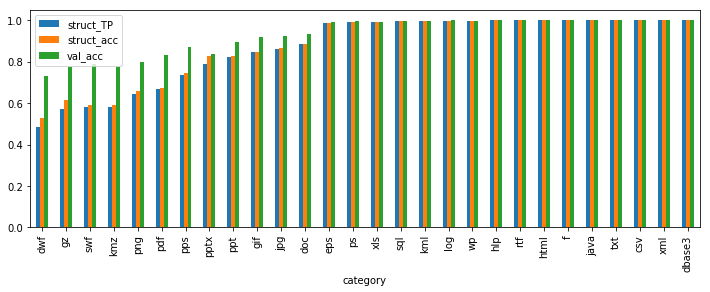

In [12]:
data.plot.bar('category', ['struct_TP', 'struct_acc', 'val_acc'], figsize=(12,4))
plt.show()

In [13]:
data.mean()

val_acc              0.931020
struct_acc           0.878964
rnd_acc              0.980286
Epochs              26.857143
struct_TP            0.872534
struct_precision     0.989923
dtype: float64

In [14]:
1-np.sum(data['struct_TP'])/28

0.12746581218775788

In [15]:
1-(np.sum(data['struct_TP'])+(1-0.22))/28

0.09960866933061496

# Use models to evaluate dataset

In [16]:
if os.path.exists(result_dir + "/evaluate.tsv"):
    os.remove(result_dir + "/evaluate.tsv")
r = Reporter2(result_dir + "/evaluate.tsv")
for cat, vset in by_categoryV.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    struct_TP = struct_acc - (1-struct_acc)*(1-rnd_acc)/rnd_acc
    
    print(cat, struct_acc, rnd_acc, struct_TP )
    r.line(cat=cat, struct_acc=struct_acc, rnd_acc=rnd_acc, struct_TP=struct_TP)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
pps 0.769 0.963 0.7601246040360701
f 1.0 1.0 1.0
kmz 0.579 0.98 0.5704081677337925
ps 0.99 1.0 0.9900000095367432
dwf 0.528 0.914 0.483588604035052
txt 1.0 1.0 1.0
dbase3 1.0 1.0 1.0
java 1.0 1.0 1.0
swf 0.573 0.954 0.55241091417281
csv 1.0 1.0 1.0
log 0.998 1.0 0.9980000257492065
png 0.627 0.967 0.614270917470189
eps 0.988 1.0 0.9879999756813049
pdf 0.688 0.975 0.6800000317891431
doc 0.873 0.993 0.8721047553163233
jpg 0.868 0.995 0.8673366548196195
hlp 1.0 1.0 1.0
rtf 1.0 1.0 1.0
gz 0.645 0.902 0.6064301384340988
gif 0.838 0.992 0.8366935452374626
sql 0.996 1.0 0.9959999918937683
html 1.0 1.0 1.0
ppt 0.826 0.979 0.822267589672116
kml 0.9

# Load evaluation data

In [17]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('struct_TP')
data3

,cat,struct_acc,rnd_acc,struct_TP
4,dwf,0.528,0.914,0.483589
8,swf,0.573,0.954,0.552411
2,kmz,0.579,0.980,0.570408
18,gz,0.645,0.902,0.606430
11,png,0.627,0.967,0.614271
13,pdf,0.688,0.975,0.680000
0,pps,0.769,0.963,0.760125
27,pptx,0.828,0.833,0.793517
22,ppt,0.826,0.979,0.822268
19,gif,0.838,0.992,0.836694


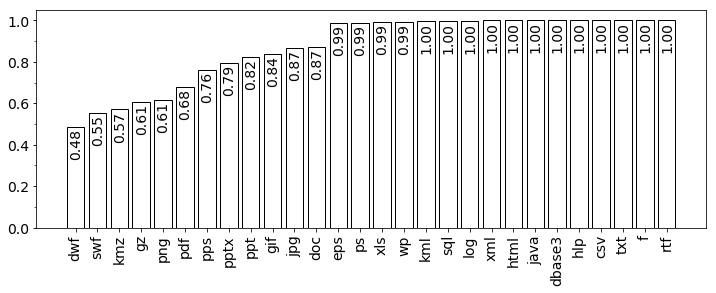

In [18]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [19]:
data3.mean()

struct_acc    0.878393
rnd_acc       0.980250
struct_TP     0.871863
dtype: float64

In [20]:
1-np.sum(data3['struct_TP'])/28

0.12813738246161654

In [55]:
1-(np.sum(data3['struct_TP'])+(1-0.48))/28

0.1091687534618977

# Train pass2 models

In [22]:
if os.path.exists(result_dir + "/pass2.tsv"):
    os.remove(result_dir + "/pass2.tsv")
r = Reporter2(result_dir + "/pass2.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
threshold=0.5
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    previous_model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    model = CLD(2, 256)
    print(cat)
    batch_size = 100
    tsampler = BlockSamplerByFile(tset)
    tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10,use_multiprocessing=False,workers=0)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10,use_multiprocessing=False,workers=0)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass2.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

gif
val_acc = 0.9632143 struct_acc= 0.953 rnd_acc= 0.991
pptx
val_acc = 0.94607145 struct_acc= 0.926 rnd_acc= 0.965
pdf
val_acc = 0.9707143 struct_acc= 0.993 rnd_acc= 0.942
jpg
val_acc = 0.97892857 struct_acc= 0.98 rnd_acc= 0.977
png
val_acc = 0.96428573 struct_acc= 0.927 rnd_acc= 0.989
dwf
val_acc = 0.9028571 struct_acc= 0.868 rnd_acc= 0.943
swf
val_acc = 0.95928574 struct_acc= 0.964 rnd_acc= 0.95
gz
val_acc = 0.92785716 struct_acc= 0.868 rnd_acc= 0.975
pps
val_acc = 0.9825 struct_acc= 0.978 rnd_acc= 0.972
kmz
val_acc = 0.9703571 struct_acc= 0.954 rnd_acc= 0.995
ppt
val_acc = 0.9792857 struct_acc= 0.983 rnd_acc= 0.983
doc
val_acc = 0.9935714 struct_acc= 0.995 rnd_acc= 0.988


# Load pass2 data

In [23]:
data2 = pd.read_csv(result_dir + "/pass2.tsv", sep='\t')
data2['struc_precision'] = data2['struct_acc'] - ((1 - data2['struct_acc'])*(1 - data2['rnd_acc'])/data2['rnd_acc'])
data2 = data2.sort_values('struc_precision')
data2

,category,val_acc,struct_acc,rnd_acc,Time,Epochs,struc_precision
5,dwf,0.902857,0.868,0.943,24m49s,30,0.860021
7,gz,0.927857,0.868,0.975,44m16s,54,0.864615
1,pptx,0.946071,0.926,0.965,46m21s,63,0.923316
4,png,0.964286,0.927,0.989,46m09s,61,0.926188
0,gif,0.963214,0.953,0.991,18m58s,26,0.952573
9,kmz,0.970357,0.954,0.995,28m58s,38,0.953769
6,swf,0.959286,0.964,0.950,20m32s,24,0.962105
8,pps,0.982500,0.978,0.972,42m54s,56,0.977366
3,jpg,0.978929,0.980,0.977,40m34s,60,0.979529
10,ppt,0.979286,0.983,0.983,49m28s,74,0.982706


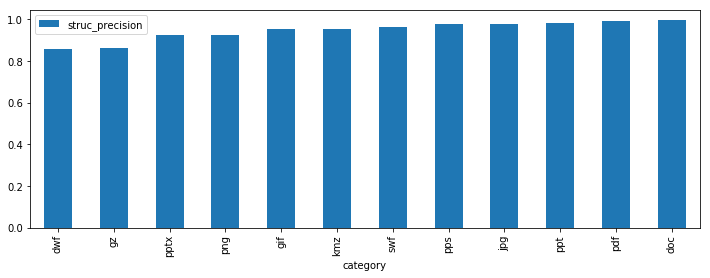

In [24]:
data2.plot.bar('category', ['struc_precision'], figsize=(12,4))
plt.show()

# Use models to evaluate dataset

In [25]:
if os.path.exists(result_dir + "/evaluate.tsv"):
    os.remove(result_dir + "/evaluate.tsv")
r = Reporter2(result_dir + "/evaluate.tsv")
for cat, vset in by_categoryV.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    struct_TP = struct_acc - (1-struct_acc)*(1-rnd_acc)/rnd_acc
    
    print(cat, struct_acc, rnd_acc, struct_TP )
    r.line(cat=cat, struct_acc=struct_acc, rnd_acc=rnd_acc, struct_TP=struct_TP)
r.close()

pps 0.772 0.972 0.7654321146636379
f 1.0 1.0 1.0
kmz 0.574 0.983 0.5666327492179088
ps 0.99 1.0 0.9900000095367432
dwf 0.53 0.914 0.48577675973099654
txt 1.0 1.0 1.0
dbase3 1.0 1.0 1.0
java 1.0 1.0 1.0
swf 0.571 0.95 0.5484210258837878
csv 1.0 1.0 1.0
log 0.999 1.0 0.9990000128746033
png 0.663 0.965 0.6507771797341979
eps 0.993 1.0 0.9929999709129333
pdf 0.699 0.98 0.6928571498081217
gz 0.624 0.9 0.5822222254600055
gif 0.849 0.991 0.8476286343120304
sql 0.994 1.0 0.9940000176429749
html 1.0 1.0 1.0
ppt 0.816 0.97 0.8103092682147488
kml 0.998 1.0 0.9980000257492065
xml 1.0 1.0 1.0
xls 0.99 1.0 0.9900000095367432
wp 0.997 1.0 0.996999979019165
pptx 0.834 0.838 0.8019092975208522


# Load evaluation data

In [26]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('struct_TP')
data3

,cat,struct_acc,rnd_acc,struct_TP
4,dwf,0.530,0.914,0.485777
8,swf,0.571,0.950,0.548421
2,kmz,0.574,0.983,0.566633
18,gz,0.624,0.900,0.582222
11,png,0.663,0.965,0.650777
13,pdf,0.699,0.980,0.692857
0,pps,0.772,0.972,0.765432
27,pptx,0.834,0.838,0.801909
22,ppt,0.816,0.970,0.810309
15,jpg,0.831,0.984,0.828252


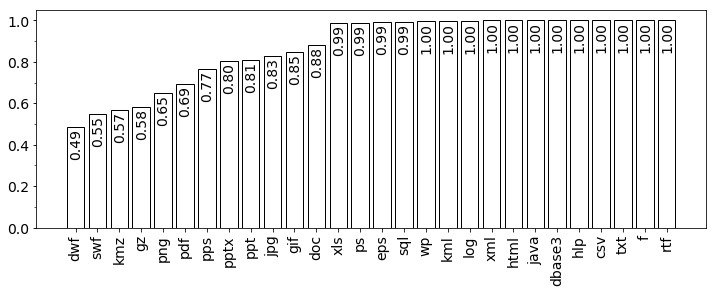

In [27]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [28]:
data3.mean()

struct_acc    0.878821
rnd_acc       0.979964
struct_TP     0.872260
dtype: float64

In [29]:
1-np.sum(data3['struct_TP'])/28

0.12774018203332627

In [47]:
1-(np.sum(data3['struct_TP'])+(1-0.49))/28

0.10952589631904053

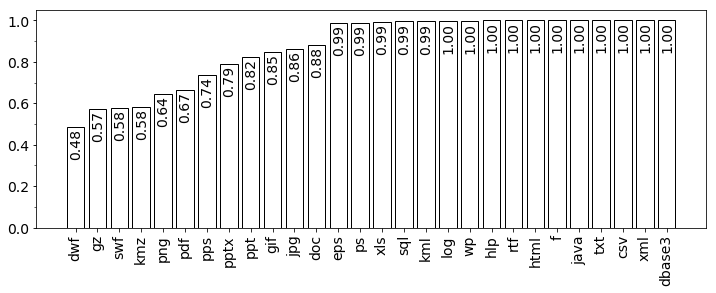

In [31]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data['category'], data['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawvset.ix_to_cat[i]
    v = data.iloc[i,6]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)

# Roc pass1

In [48]:
from sklearn.metrics import roc_curve, auc

In [49]:
by_category = rawset.by_category()
cat = 'jpg'
dataset = by_category[cat]
dataset.rebuild_categories(categories=['jpg', 'zzz'])

model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

In [50]:
tsampler = BlockSamplerByFile(dataset)
tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat='jpg')

tbenc = BatchEncoder(tsampler,
                     batch_size=1000,
                     xs_encoder='one_hot')
xs, ys = next(iter(tbenc))

In [51]:
datalen = len(xs)
predict = model.predict(xs, batch_size=100)
# predict = np.argmax(predict, axis=-1)

In [52]:
score = predict[:,0]-predict[:,1]
mask = score > 0.9
print(len(score[mask]), len(score))
fpr, tpr, thresholds = roc_curve(ys[:,0][mask], score[mask])
mask = thresholds > 0
fpr[mask], tpr[mask], thresholds[mask]

375 1000


/home/atila.alr/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan]),
 array([0.        , 0.00266667, 0.05333333, 0.05866667, 0.072     ,
        0.08266667, 0.16      , 0.17066667, 0.184     , 0.18933333,
        0.28533333, 0.29066667, 0.336     , 0.34133333, 0.66933333,
        0.67466667, 0.70666667, 0.712     , 0.74666667, 0.752     ,
        1.        ]),
 array([1.9999948 , 0.9999947 , 0.9999693 , 0.9999671 , 0.9999609 ,
        0.99996066, 0.99988127, 0.9998724 , 0.9998482 , 0.99984235,
        0.99961215, 0.9996036 , 0.99953306, 0.9995309 , 0.9927633 ,
        0.99190974, 0.9903399 , 0.99014884, 0.98481095, 0.9846745 ,
        0.90038383], dtype=float32))

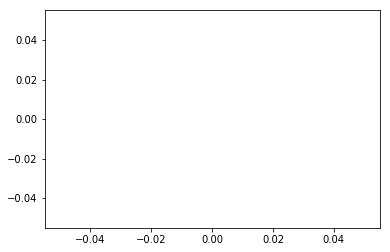

In [53]:
plt.plot(fpr, tpr)

(array([495.,  19.,  13.,   7.,   7.,  13.,  14.,  15.,  22., 395.]),
 array([-9.9997312e-01, -7.9997635e-01, -5.9997958e-01, -3.9998278e-01,
        -1.9998600e-01,  1.0788441e-05,  2.0000757e-01,  4.0000436e-01,
         6.0000116e-01,  7.9999793e-01,  9.9999470e-01], dtype=float32),
 <a list of 10 Patch objects>)

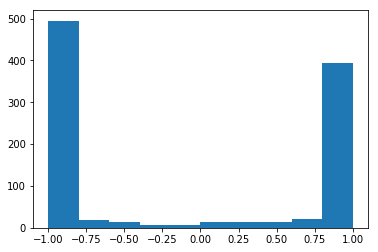

In [54]:
plt.hist(predict[:,0]-predict[:,1])

# Use models to evaluate dataset - using pass2

In [39]:
def rndgen():
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        yield rdata

In [40]:
if os.path.exists(result_dir + "/evaluate2.tsv"):
    os.remove(result_dir + "/evaluate2.tsv")
r = Reporter2(result_dir + "/evaluate2.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model1 = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=1000,
                         xs_encoder='one_hot')
    xs, _ = next(iter(tbenc))
    datalen = len(xs)
    predict = model1.predict(xs, batch_size=100)
    predict = np.argmax(predict, axis=-1)

    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        model2 = tf.keras.models.load_model(result_dir + '/%s_pass2.h5' % cat)
        xs = xs[predict==0]
        datalen = len(xs)
        predict = model2.predict(xs, batch_size=100)
        predict = np.argmax(predict, axis=-1)

    not_random = len(predict[predict==0])/datalen
    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        predict = model2.predict_generator(rndgen(), steps=10)
    else:
        predict = model1.predict_generator(rndgen(), steps=10)
    predict = np.argmax(predict, axis=-1)   
    random = len(predict[predict==1])/(10*100)
    
    true_not_random = not_random - (1-not_random)*(1-random)/random
    
    print(cat, not_random, random, true_not_random )
    r.line(cat=cat, not_random=not_random, random=random, true_not_random=true_not_random)
r.close()

dbase3 1.0 1.0 1.0
txt 1.0 1.0 1.0
gif 0.9517014270032931 0.989 0.9511642335725916
f 1.0 1.0 1.0
xls 0.994 1.0 0.994
dwf 0.8422619047619048 0.929 0.8302065713260547
hlp 1.0 1.0 1.0
log 1.0 1.0 1.0
swf 0.8850393700787401 0.964 0.8807462345215147
png 0.8601583113456465 0.99 0.8587457690360065
rtf 0.999 1.0 0.999
pdf 0.9468791500664011 0.947 0.9439061774724404
jpg 0.9810055865921787 0.983 0.9806770972453497
ppt 0.9520383693045563 0.99 0.9515539083884407
eps 0.998 1.0 0.998
ps 0.982 1.0 0.982
html 1.0 1.0 1.0
kml 0.999 1.0 0.999
wp 0.995 1.0 0.995
pps 0.9489144316730523 0.977 0.9477118031453965
kmz 0.9063772048846676 0.987 0.9051440778973329
csv 1.0 1.0 1.0
xml 1.0 1.0 1.0
doc 0.9801324503311258 0.994 0.9800125254840301
gz 0.8301369863013699 0.967 0.8243402133416442
pptx 0.8687727825030377 0.971 0.8648535350185764
java 1.0 1.0 1.0
sql 0.998 1.0 0.998


# Load evaluation data 2

In [41]:
data4 = pd.read_csv(result_dir + "/evaluate2.tsv", sep='\t')
data4 = data4.sort_values('true_not_random')
data4

,cat,not_random,random,true_not_random
24,gz,0.830137,0.967,0.824340
5,dwf,0.842262,0.929,0.830207
9,png,0.860158,0.990,0.858746
25,pptx,0.868773,0.971,0.864854
8,swf,0.885039,0.964,0.880746
20,kmz,0.906377,0.987,0.905144
11,pdf,0.946879,0.947,0.943906
19,pps,0.948914,0.977,0.947712
2,gif,0.951701,0.989,0.951164
13,ppt,0.952038,0.990,0.951554


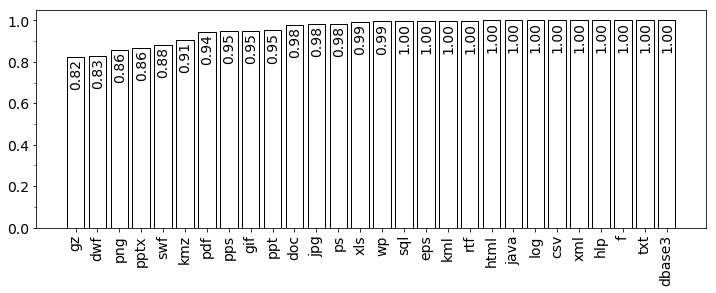

In [42]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data4['cat'], data4['true_not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data4.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [43]:
data4.mean()

not_random         0.961372
random             0.988857
true_not_random    0.960145
dtype: float64

In [44]:
1-np.sum(data4['true_not_random'])/28

0.03985492334109353

In [45]:
1-(np.sum(data4['true_not_random'])+(1-0.62))/28

0.02628349476966496